# 資料準備

In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import data
#import dataset

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

# 設定參數

In [2]:
# Number of color channels for the images: 1 channel for gray-scale.
num_channels =3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['high','middle','low']
#classes = ['0','1','2','3','4','5','6','7','8','9']
num_classes = len(classes)

# batch size
batchSize = 20

# validation split
validation_size = .15
testdation_size = .15

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'U:/git/fish_Recognition/work/train'
#test_path = 'U:/git/fish_Recognition/work/test'
checkpoint_dir = "./set_models/"

# 建立共用函數

In [3]:
#data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
#test_data = dataset.read_test_set(test_path, img_size, classes, validation_size=0)
data = data.read_train_sets(train_path, img_size, classes, validation_size=validation_size,testdation_size=testdation_size)

Reading training images
Loading high files (Index: 0)
Loading middle files (Index: 1)
Loading low files (Index: 2)


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))
print("-Testdation-set:\t{}".format(len(data.test.labels)))

Size of:
- Training-set:		343
- Validation-set:	73
-Testdation-set:	74


In [5]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1),
                       name ='W')

In [6]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape)
                       , name = 'b')

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], 
                        padding='SAME')

In [8]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], 
                          strides=[1,2,2,1], 
                          padding='SAME')

# 輸入層 Input Layer

In [9]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder("float",shape=[None, img_size_flat]
                       ,name="x")    
    x_image = tf.reshape(x, [-1, img_size, img_size,num_channels])

# Convolutional Layer 1

In [10]:
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,num_channels,16])
    b1 = bias([16])
    Conv1=conv2d(x_image, W1)+ b1
    C1_Conv = tf.nn.relu(Conv1 )

In [11]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

# Convolutional Layer 2

In [12]:
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    Conv2=conv2d(C1_Pool, W2)+ b2
    C2_Conv = tf.nn.relu(Conv2)

In [13]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv) 

# Fully Connected Layer

In [14]:
with tf.name_scope('D_Flat'):
    layer_shape = C2_Pool.get_shape()
    num_features = layer_shape[1:4].num_elements()
    D_Flat = tf.reshape(C2_Pool, [-1, num_features])

In [15]:
with tf.name_scope('D_Hidden_Layer'):
    W3= weight([num_features, 128])
    b3= bias([128])
    D_Hidden = tf.nn.relu(
                  tf.matmul(D_Flat, W3)+b3)
    D_Hidden_Dropout= tf.nn.dropout(D_Hidden, 
                                keep_prob=0.5)

# 輸出層Output

In [16]:
with tf.name_scope('Output_Layer'):
    W4 = weight([128,num_classes])
    b4 = bias([num_classes])
    y_predict= tf.nn.softmax(
                 tf.matmul(D_Hidden_Dropout,
                           W4)+b4)

# 設定訓練模型最佳化步驟

In [17]:
with tf.name_scope("optimizer"):
    
    y_label = tf.placeholder("float", shape=[None, num_classes], 
                              name="y_label")
    
    loss_function = tf.reduce_mean(
                      tf.nn.softmax_cross_entropy_with_logits
                         (logits=y_predict , 
                          labels=y_label))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.00001) \
                    .minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# 設定評估模型

In [18]:
with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1),
                                  tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) # 非零為一，的平均差

# 訓練模型

In [19]:
trainEpochs = 200
train_batch_size = batchSize
valid_batch_size = 67
totalBatchs = int(len(data.train.labels)/batchSize)
epoch_list=[];accuracy_list=[];loss_list=[];
from time import time
startTime=time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
for epoch in range(trainEpochs):

    
    for i in range(totalBatchs):
        #batch_x, batch_y = mnist.train.next_batch(batchSize)
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]
        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        
        #sess.run(optimizer,feed_dict={x: batch_x, y_label: batch_y})
        sess.run(optimizer,feed_dict={x: x_batch, y_label: y_true_batch})
    x_valid_batch, y_vtrue_batch, _, valid_cls_batch = data.valid.next_batch(valid_batch_size)
    x_valid_batch = x_valid_batch.reshape(valid_batch_size, img_size_flat)
    loss,acc = sess.run([loss_function,accuracy],
                        feed_dict={x: x_valid_batch, 
                                   y_label: y_vtrue_batch})

    epoch_list.append(epoch)
    loss_list.append(loss);accuracy_list.append(acc)    
    
    print("Train Epoch:", '%02d' % (epoch+1), \
          "Loss=","{:.9f}".format(loss)," Accuracy=",acc)
    
duration =time()-startTime
print("Train Finished takes:",duration)         

Train Epoch: 01 Loss= 1.159288645  Accuracy= 0.3283582
Train Epoch: 02 Loss= 1.102284074  Accuracy= 0.37313432
Train Epoch: 03 Loss= 0.957763195  Accuracy= 0.58208954
Train Epoch: 04 Loss= 0.952899933  Accuracy= 0.5671642
Train Epoch: 05 Loss= 0.936542869  Accuracy= 0.58208954
Train Epoch: 06 Loss= 0.899921000  Accuracy= 0.64179105
Train Epoch: 07 Loss= 0.812145114  Accuracy= 0.76119405
Train Epoch: 08 Loss= 0.811115563  Accuracy= 0.73134327
Train Epoch: 09 Loss= 0.790419161  Accuracy= 0.76119405
Train Epoch: 10 Loss= 0.807279289  Accuracy= 0.7164179
Train Epoch: 11 Loss= 0.733747780  Accuracy= 0.8208955
Train Epoch: 12 Loss= 0.753382802  Accuracy= 0.8208955
Train Epoch: 13 Loss= 0.727014601  Accuracy= 0.8358209
Train Epoch: 14 Loss= 0.696673989  Accuracy= 0.8507463
Train Epoch: 15 Loss= 0.720212460  Accuracy= 0.8507463
Train Epoch: 16 Loss= 0.744103432  Accuracy= 0.8208955
Train Epoch: 17 Loss= 0.724070668  Accuracy= 0.8358209
Train Epoch: 18 Loss= 0.688485324  Accuracy= 0.86567163
Tr

Train Epoch: 149 Loss= 0.623955011  Accuracy= 0.9402985
Train Epoch: 150 Loss= 0.616659224  Accuracy= 0.9402985
Train Epoch: 151 Loss= 0.619753361  Accuracy= 0.92537314
Train Epoch: 152 Loss= 0.603101194  Accuracy= 0.95522386
Train Epoch: 153 Loss= 0.634229660  Accuracy= 0.92537314
Train Epoch: 154 Loss= 0.606481731  Accuracy= 0.9701493
Train Epoch: 155 Loss= 0.603001356  Accuracy= 0.98507464
Train Epoch: 156 Loss= 0.612717748  Accuracy= 0.9402985
Train Epoch: 157 Loss= 0.612422526  Accuracy= 0.9402985
Train Epoch: 158 Loss= 0.624255478  Accuracy= 0.9402985
Train Epoch: 159 Loss= 0.593749285  Accuracy= 0.98507464
Train Epoch: 160 Loss= 0.600213587  Accuracy= 0.9701493
Train Epoch: 161 Loss= 0.587282002  Accuracy= 0.98507464
Train Epoch: 162 Loss= 0.618160784  Accuracy= 0.9701493
Train Epoch: 163 Loss= 0.598093688  Accuracy= 0.9701493
Train Epoch: 164 Loss= 0.614165723  Accuracy= 0.95522386
Train Epoch: 165 Loss= 0.605232298  Accuracy= 0.9701493
Train Epoch: 166 Loss= 0.622921407  Accur

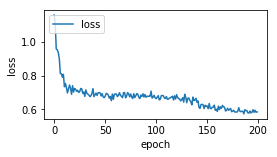

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')

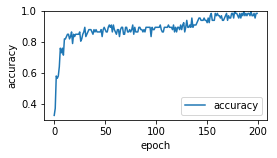

In [22]:
plt.plot(epoch_list, accuracy_list,label="accuracy" )
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.3,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


# 評估模型準確率

In [23]:
len(data.test.labels)

74

In [24]:
test_size = len(data.test.labels)
test_num = int(int(test_size)/2)
test_index = int(test_size)
x_test_batch, y_test_batch, _, test_cls_batch = data.test.next_batch(test_size)
x_test_batch = x_test_batch.reshape(test_size, img_size_flat)
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: x_test_batch,
                                   y_label: y_test_batch}))


Accuracy: 0.9864865


In [25]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: x_test_batch[:test_num],
                                   y_label: y_test_batch[:test_num]}))


Accuracy: 1.0


In [26]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x:x_test_batch[test_num:],
                                   y_label: y_test_batch[test_num:]}))

Accuracy: 0.9189189


# 預測機率

In [27]:
y_predict=sess.run(y_predict, 
                   feed_dict={x: x_test_batch[:test_index]})

In [28]:
y_predict[:5]

array([[9.2449482e-04, 8.5470115e-04, 9.9822074e-01],
       [1.6485093e-09, 5.1696688e-08, 1.0000000e+00],
       [1.4632819e-06, 3.2778819e-06, 9.9999523e-01],
       [1.7523236e-04, 6.7978185e-01, 3.2004294e-01],
       [9.4934481e-01, 1.6696377e-02, 3.3958837e-02]], dtype=float32)

# 預測結果

In [29]:
prediction_result=sess.run(tf.argmax(y_predict,1),
                           feed_dict={x:x_test_batch[:test_index] ,
                                      y_label:y_test_batch[:test_index]})

In [30]:
prediction_result[:20]


array([2, 2, 2, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 2, 2, 1, 2],
      dtype=int64)

In [31]:
y_test_batch[:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [32]:
import numpy as np
def show_images_labels_predict(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(15, 20)
    for i in range(0, 10):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(np.reshape(images[i],(img_size, img_size,num_channels)), 
                  cmap='binary')
        ax.set_title("label=" +classes[np.argmax(labels[i])]+
                     ",predict="+classes[np.argmax(labels[i])]
                     ,fontsize=9) 
    plt.show()

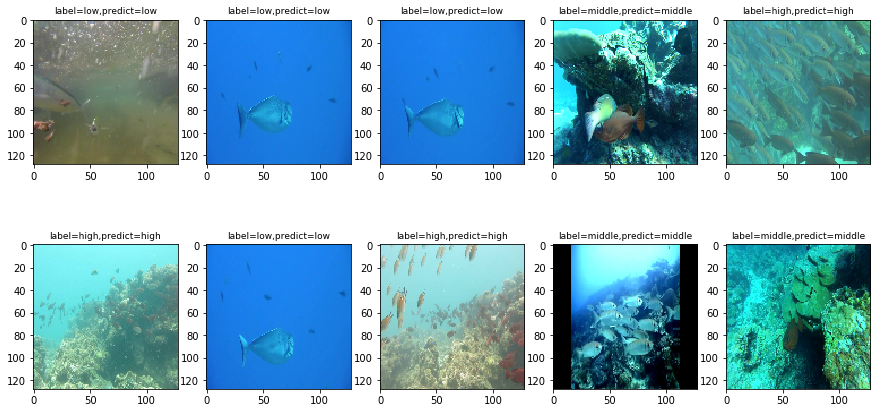

In [33]:
show_images_labels_predict(data.test.images,data.test.labels,prediction_result)

# 找出預測錯誤

In [34]:
for i in range(66):
    if prediction_result[i]!=np.argmax(data.test.labels[i]):
        print("i="+str(i)+
              "   label=",np.argmax(data.test.labels[i]),
              "predict=",prediction_result[i])

i=60   label= 2 predict= 0


In [35]:
def show_images_labels_predict_error(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(15, 20)
    i=0;j=0
    while i<10:
        if prediction_result[j]!=np.argmax(labels[j]):
            ax=plt.subplot(5,5, 1+i)
            ax.imshow(np.reshape(images[j],(img_size, img_size,num_channels)), 
                      cmap='binary')
            ax.set_title("j="+str(j)+
                         ",l=" +str(np.argmax(labels[j]))+
                         ",p="+str(prediction_result[j])
                         ,fontsize=9) 
            i=i+1
        j=j+1
        if j >= len(prediction_result):
            break
    plt.show()

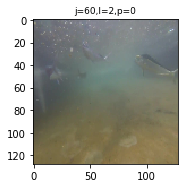

In [36]:
show_images_labels_predict_error(data.test.images,data.test.labels,prediction_result)

In [37]:
saver = tf.train.Saver()

In [38]:
save_path = saver.save(sess, "set_model/CNN_work_number_of_fish")

In [39]:
print("Model saved in file: %s" % save_path)

Model saved in file: set_model/CNN_work_number_of_fish


In [40]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN_work_number_of_fish',sess.graph)

In [41]:
#sess.close()